Student Name: Gerald Wanjala
Student Pace: DSF-FT12-Hybrid
Instructor Name: Samuel Karu

# Data Science Project: Analyzing Box Office Film Success

##  Business Understanding

### Objective
To help a new movie studio make informed decisions about the types of movies to produce in order to maximize box office returns.

### Business Problem
The company needs insights into what characteristics contribute most to a film's box office success. By analyzing historical data on box office earnings and production budgets, we aim to identify patterns that can guide production and investment strategies.

### Main Questions
- Do higher production budgets result in higher box office returns?
- Which genres or studios consistently generate high grossing films?
- Is there a correlation between budget and return on investment (ROI)?

### Hypothesis
> Movies with higher production budgets tend to earn more at the box office and achieve a better ROI.


##  Data Loading

In this step, we load the Box Office Mojo (BOM) data and connect to the IMDb SQLite database to extract key tables:

- Load the BOM movie gross data from a compressed CSV file.
- Connect to the IMDb database and load the following tables:
  - `movie_basics`: Basic movie information (title, year, runtime, genres).
  - `movie_ratings`: Movie ratings and vote counts.
  - `directors`: Director information linked to movies.
  - `writers`: Writer information linked to movies.
  - `persons`: Names and details of people (directors, writers, etc.).

Preview the datasets to understand their structure before merging and analysis.


In [4]:
import pandas as pd
import sqlite3

# Load BOM dataset
bom_df = pd.read_csv('../zipped-data/bom.movie_gross.csv.gz')

# Connect to IMDB SQLite database
conn = sqlite3.connect('../zipped-data/im.db')

# Load key tables
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
directors = pd.read_sql_query("SELECT * FROM directors", conn)
writers = pd.read_sql_query("SELECT * FROM writers", conn)
persons = pd.read_sql_query("SELECT * FROM persons", conn)

# Preview basics



###  Preview BOM Data
a quick look at the first few rows of the Box Office Mojo (BOM) dataset to understand its structure and the available columns.


In [5]:
# Preview all loaded datasets

print("=== BOM Dataset ===")
print(bom_df.head(), "\n")

print("=== Movie Basics ===")
print(movie_basics.head(), "\n")

print("=== Movie Ratings ===")
print(movie_ratings.head(), "\n")

print("=== Directors ===")
print(directors.head(), "\n")

print("=== Writers ===")
print(writers.head(), "\n")

print("=== Persons ===")
print(persons.head())


=== BOM Dataset ===
                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010   

=== Movie Basics ===
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Ba

### Data Cleaning - Check for Missing Values and Duplicates

We'll define a function that checks for missing values and duplicates in any dataframe. This function will:

1. Check for duplicate rows.
2. Check for missing values in each column.

We can apply this function to all datasets to ensure their cleanliness before proceeding with further steps.


In [6]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [7]:

# Check for missing values and duplicates
def check_duplicates_missing(df):
    print('Duplicated:')
    print(df.duplicated().value_counts())
    print('\nMissing values:')
    print(df.isna().sum())
    return df
# Run the check on bom_clean



### Data Cleaning - Check for Missing Values and Duplicates

We will now apply the `check_duplicates_missing` function to each of the datasets to check for any duplicate rows and missing values.


In [8]:
### Data Cleaning - Check for Missing Values and Duplicates


# Run the check on bom_df
print("BOM DataFrame:")
check_duplicates_missing(bom_df)

# Run the check on movie_basics
print("\nMovie Basics DataFrame:")
check_duplicates_missing(movie_basics)

# Run the check on movie_ratings
print("\nMovie Ratings DataFrame:")
check_duplicates_missing(movie_ratings)

# Run the check on directors
print("\nDirectors DataFrame:")
check_duplicates_missing(directors)

# Run the check on writers
print("\nWriters DataFrame:")
check_duplicates_missing(writers)

# Run the check on persons
print("\nPersons DataFrame:")
check_duplicates_missing(persons)


BOM DataFrame:
Duplicated:
False    3387
Name: count, dtype: int64

Missing values:
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

Movie Basics DataFrame:
Duplicated:
False    146144
Name: count, dtype: int64

Missing values:
movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Movie Ratings DataFrame:
Duplicated:
False    73856
Name: count, dtype: int64

Missing values:
movie_id         0
averagerating    0
numvotes         0
dtype: int64

Directors DataFrame:
Duplicated:
False    163535
True     127639
Name: count, dtype: int64

Missing values:
movie_id     0
person_id    0
dtype: int64

Writers DataFrame:
Duplicated:
False    178352
True      77521
Name: count, dtype: int64

Missing values:
movie_id     0
person_id    0
dtype: int64

Persons DataFrame:
Duplicated:
False    606648
Name: count, 

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


## Handling Missing Values with a Generalized Function
To ensure consistency and efficiency in handling missing values across all DataFrames, we define a reusable function filling_missing():

Drops columns with more than 50% missing values.

# Fills numeric columns:

Uses the mean if the distribution is fairly symmetrical (low skewness).

Uses the median if the distribution is skewed.

# Fills categorical columns:

Uses the most frequent value (mode).

If mode is not available, it fills with "Unknown".

We can apply this function to each DataFrame to standardize the cleaning process.



In [9]:
# Updated function to handle missing values and duplicates
def filling_missing(df):
    # Dropping duplicate rows
    df = df.drop_duplicates()

    # Dropping columns with more than 50% missing values
    df = df.dropna(thresh=0.3 * len(df), axis=1)


    # Filling missing values in numeric columns
    for col in df.select_dtypes(include=['number']).columns:
        if df[col].isna().sum() > 0:
            skewness = df[col].skew()
            fill_value = df[col].mean() if abs(skewness) < 0.5 else df[col].median()
            df[col].fillna(fill_value, inplace=True)
    
    # Filling missing values in categorical columns
    for col in df.select_dtypes(exclude=['number']).columns:
        if df[col].isna().sum() > 0:
            most_frequent = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col].fillna(most_frequent, inplace=True)

    return df


### Handling Missing Values and Duplicates

In this section, we apply a custom function to handle missing values and remove duplicates across all our datasets

In [10]:
# Apply filling_missing function to all DataFrames

bom_df = filling_missing(bom_df)
movie_basics = filling_missing(movie_basics)
movie_ratings = filling_missing(movie_ratings)
directors = filling_missing(directors)
writers = filling_missing(writers)
persons = filling_missing(persons)


C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_3444\73514346.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(fill_value, inplace=True)
C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_3444\73514346.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [22]:


# Convert gross columns to numeric
bom_df['domestic_gross'] = pd.to_numeric(bom_df['domestic_gross'], errors='coerce')
bom_df['foreign_gross'] = pd.to_numeric(bom_df['foreign_gross'], errors='coerce')


### Check for Missing Values and Duplicates after Cleaning

After applying the data cleaning functions, we  checed each DataFrame for missing values and duplicates:

In [11]:
###  Check for Missing Values and Duplicates after Cleaning


# Run the check on bom_df
print("BOM DataFrame:")
check_duplicates_missing(bom_df)

# Run the check on movie_basics
print("\nMovie Basics DataFrame:")
check_duplicates_missing(movie_basics)

# Run the check on movie_ratings
print("\nMovie Ratings DataFrame:")
check_duplicates_missing(movie_ratings)

# Run the check on directors
print("\nDirectors DataFrame:")
check_duplicates_missing(directors)

# Run the check on writers
print("\nWriters DataFrame:")
check_duplicates_missing(writers)

# Run the check on persons
print("\nPersons DataFrame:")
check_duplicates_missing(persons)


BOM DataFrame:
Duplicated:
False    3387
Name: count, dtype: int64

Missing values:
title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

Movie Basics DataFrame:
Duplicated:
False    146144
Name: count, dtype: int64

Missing values:
movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

Movie Ratings DataFrame:
Duplicated:
False    73856
Name: count, dtype: int64

Missing values:
movie_id         0
averagerating    0
numvotes         0
dtype: int64

Directors DataFrame:
Duplicated:
False    163535
Name: count, dtype: int64

Missing values:
movie_id     0
person_id    0
dtype: int64

Writers DataFrame:
Duplicated:
False    178352
Name: count, dtype: int64

Missing values:
movie_id     0
person_id    0
dtype: int64

Persons DataFrame:
Duplicated:
False    606648
Name: count, dtype: int64

Missing values:
person_id             0
primary_name     

,person_id,primary_name,primary_profession
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,"production_designer,art_department,set_decorator"
...,...,...,...
606643,nm9990381,Susan Grobes,actress
606644,nm9990690,Joo Yeon So,actress
606645,nm9991320,Madeline Smith,actress
606646,nm9991786,Michelle Modigliani,producer


### Function to Remove Outliers Using IQR

The following function was used to remove outliers from specified columns in a DataFrame based on the Interquartile Range (IQR) method.



In [12]:
# remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df




### Remove Outliers using IQR (Interquartile Range)

The function `remove_outliers()` has been applied to remove outliers from the relevant columns in each DataFrame using the IQR method.


In [23]:

movie_ratings = remove_outliers(movie_ratings, ['averagerating', 'numvotes'])
bom_df = remove_outliers(bom_df, ['domestic_gross', 'foreign_gross'])
movie_basics = remove_outliers(movie_basics, ['runtime_minutes'])
movie_ratings = remove_outliers(movie_ratings, ['averagerating', 'numvotes'])


### Merging DataFrames and Final Data Cleaning

1. **Merging the DataFrames:**
   - The `bom_df` (Box Office Movies) DataFrame is merged with the `movie_basics` DataFrame based on the `title` and `primary_title` columns.
   - Then, it is merged with the `movie_ratings` DataFrame using `movie_id`.
   - After that, the `directors` and `writers` DataFrames are merged on `movie_id` as well.

2. **Handling Duplicates:**
   - Any duplicates in the resulting `final_df` are dropped using `drop_duplicates()` to ensure that there are no repeated rows in the final merged DataFrame.

3. **Filling Missing Values:**
   - The code includes an option to fill missing values with `'Unknown'`, but this step has been commented out in the current execution.

4. **Final Check:**
   - The `final_df.info()` is called to inspect the DataFrame after all the merging and cleaning steps, ensuring that it contains the expected number of rows and columns, and that the data is ready for analysis.


In [24]:
# Merge BOM DataFrame with Movie Basics DataFrame based on title and primary_title
merged_df = pd.merge(bom_df, movie_basics, left_on='title', right_on='primary_title', how='inner')

# merging with movie_ratings
final_df = pd.merge(merged_df, movie_ratings, on='movie_id', how='inner')

# Merging with directors
final_df = pd.merge(final_df, directors, on='movie_id', how='left')

# Merging with writers
final_df = pd.merge(final_df, writers, on='movie_id', how='left')

# Drop duplicates
final_df = final_df.drop_duplicates()

# Fill missing values
#final_df.fillna('Unknown', inplace=True)

# Final check
final_df.info(), 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            462 non-null    object 
 1   studio           462 non-null    object 
 2   domestic_gross   462 non-null    float64
 3   foreign_gross    462 non-null    float64
 4   year             462 non-null    int64  
 5   movie_id         462 non-null    object 
 6   primary_title    462 non-null    object 
 7   original_title   462 non-null    object 
 8   start_year       462 non-null    int64  
 9   runtime_minutes  462 non-null    float64
 10  genres           462 non-null    object 
 11  averagerating    462 non-null    float64
 12  numvotes         462 non-null    int64  
 13  person_id_x      460 non-null    object 
 14  person_id_y      442 non-null    object 
dtypes: float64(4), int64(3), object(8)
memory usage: 54.3+ KB


(None,)

<Figure size 1200x600 with 0 Axes>

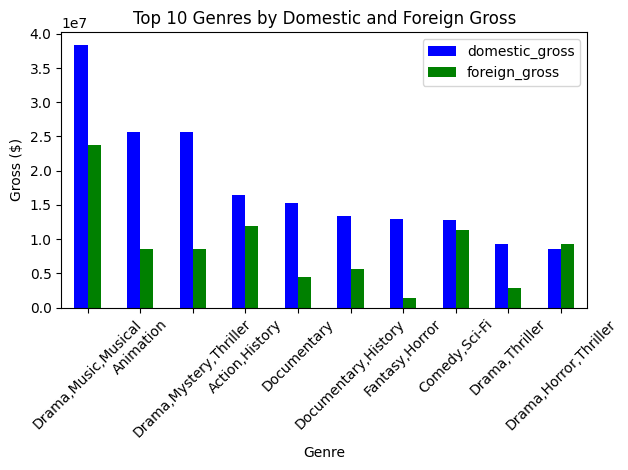

In [25]:
# Bar plot for top 10 genres by average domestic and foreign gross
genre_performance = final_df.explode('genres').groupby('genres')[['domestic_gross', 'foreign_gross']].mean()
genre_performance_sorted = genre_performance.sort_values(by=['domestic_gross', 'foreign_gross'], ascending=False)

# Plot top 10 genres
plt.figure(figsize=(12, 6))
genre_performance_sorted.head(10).plot(kind='bar', color=['blue', 'green'])
plt.title('Top 10 Genres by Domestic and Foreign Gross')
plt.xlabel('Genre')
plt.ylabel('Gross ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
## 📈 6. Visualizations
-   Bar plots for top 10 genres by average gross                            c
- Heatmaps for correlations
- Time series of average gross by year
- Box plots comparing domestic vs. foreign gross
- Scatter plots of rating vs. gross
